In [12]:
import pandas as pd
import seaborn as sns
import requests as req
import json
from scipy.stats import variation
from ipyleaflet import Map, basemaps, basemap_to_tiles, Circle
import matplotlib.pyplot as plt
from sklearn.utils import resample
%matplotlib inline

In [13]:
# getting tacks for page 0 and first 100 entries 
dat = req.get('https://envirocar.org/api/stable/tracks', params={'page': 4}).json()['tracks']

In [14]:
# getting the ids
ids = [_['id'] for _ in dat]

In [16]:
# first track data
data = pd.read_csv(f'https://envirocar.org/api/stable/tracks/{ids[0]}.csv', sep=';', engine='python')
data.head()

,id,CO2(kg/h),GPS Altitude(m),GPS HDOP(precision),GPS Bearing(deg),Consumption(l/h),MAF(l/s),Speed(km/h),GPS Speed(km/h),Rpm(u/min),Throttle Position(%),GPS VDOP(precision),GPS Accuracy(%),GPS PDOP(precision),Intake Temperature(c),Engine Load(%),longitude,latitude,time
0,5c14983044ea850302b128d8,,126.456921,1.6,2.282451,,,30.0,30.486065,1444.0,16.0,2.2,3.0,2.7,,23.921567916870117,7.212854,51.504330,2018-12-15T04:25:45Z
1,5c14983044ea850302b128da,,126.320146,1.1,357.988800,,,30.0,30.715256,1453.0,,1.4,3.0,1.8,44.0,,7.212846,51.504483,2018-12-15T04:25:47Z
2,5c14983044ea850302b128db,4.4341321338318656,126.184402,1.4,358.158539,1.8868647378007937,5.739999771118164,30.0,30.743151,,17.0,2.4,3.0,2.8,44.0,,7.212831,51.504639,2018-12-15T04:25:49Z
3,5c14983044ea850302b128dc,,126.161344,0.9,355.355194,,,30.0,30.998093,1485.0,,1.4,3.0,1.6,,26.66666603088379,7.212823,51.504719,2018-12-15T04:25:50Z
4,5c14983044ea850302b128dd,,126.096456,0.9,350.870148,,,31.0,31.599148,1503.0,,1.4,3.0,1.6,44.0,,7.212780,51.504881,2018-12-15T04:25:52Z



### Processing of Empty values

In [17]:
single_track = pd.read_csv(f'https://envirocar.org/api/stable/tracks/{ids[0]}.csv', sep=';', engine='python')
data = single_track.copy()
# requesting data for each track

for _ in ids[1:10]:    
    data = data.append(pd.read_csv(f'https://envirocar.org/api/stable/tracks/{_}.csv', sep=';', engine='python'))

/home/bliss/.local/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


### Analysis

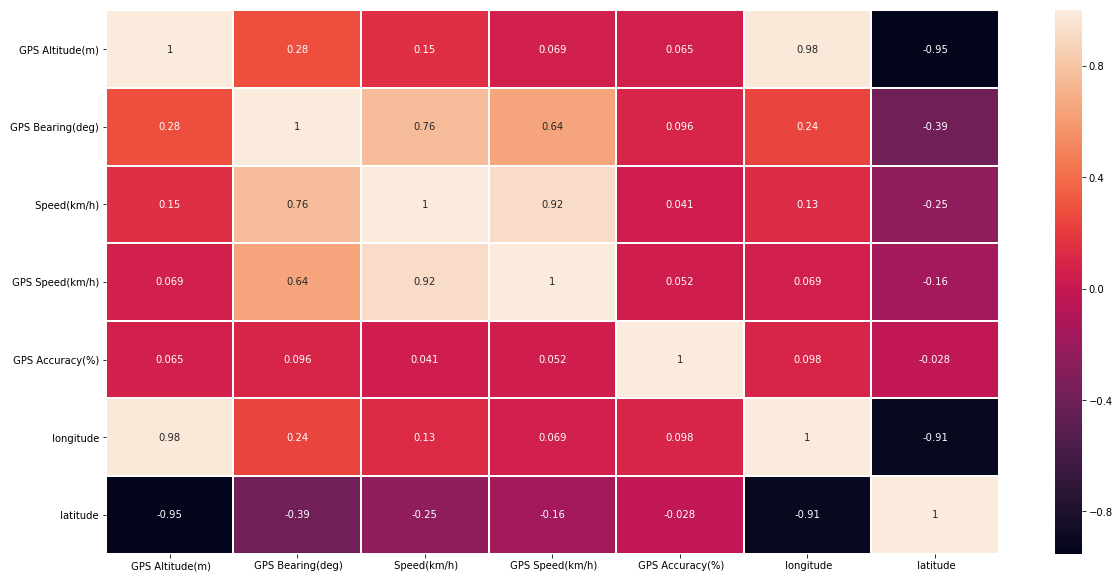

In [83]:
# identifying correlation between properties
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(data.corr(), linewidths=1, annot=True, ax=ax)

In [88]:
# variance 
single_track.var()

 GPS Altitude(m)        27.292268
 GPS Bearing(deg)    11876.442558
 Speed(km/h)            53.939235
 GPS Speed(km/h)        69.702756
 GPS Accuracy(%)         3.366600
 longitude               0.000003
 latitude                0.000027
dtype: float64

In [90]:
single_track.head()

,id,CO2(kg/h),GPS HDOP(precision),GPS Altitude(m),GPS Bearing(deg),MAF(l/s),Consumption(l/h),Speed(km/h),GPS Speed(km/h),Rpm(u/min),Throttle Position(%),GPS VDOP(precision),GPS Accuracy(%),GPS PDOP(precision),Intake Temperature(c),Engine Load(%),longitude,latitude,time
0,5c14981c44ea850302b127ff,,1.1,143.151468,304.339874,,,46.0,45.643612,1369.0,,1.2,6.0,1.7,,,7.218317,51.484903,2018-12-15T04:14:27Z
1,5c14981c44ea850302b12801,,1.7,142.344093,305.963837,,,46.0,45.915009,,,1.4,8.0,2.2,42.0,,7.217720,51.485168,2018-12-15T04:14:31Z
2,5c14981c44ea850302b12802,2.92003832880952,1.1,141.856606,306.094635,3.7799999713897705,1.2425695016210723,45.0,45.495461,,,1.2,4.0,1.7,43.0,,7.217277,51.485371,2018-12-15T04:14:34Z
3,5c14981c44ea850302b12803,,1.0,141.500532,320.720123,,,45.0,44.182362,1331.0,,1.3,3.0,1.6,,,7.217005,51.485510,2018-12-15T04:14:36Z
4,5c14981c44ea850302b12804,,1.3,140.547116,342.445129,,,45.0,45.063362,,,1.5,3.0,2.0,42.0,,7.216808,51.485814,2018-12-15T04:14:39Z


### Single Track

In [20]:
layer = basemap_to_tiles(basemaps.Stamen.Toner)
m = Map(zoom=13, center=(single_track[' latitude'][0], single_track[' longitude'][0]))

col = int("8a2be2", 16)

for i, j, k in zip(single_track[' longitude'][1:], single_track[' latitude'][1:], single_track[' GPS Speed(km/h)'][1:]):
    circle = Circle()
    circle.location = (j, i)
    circle.radius = 2
    circle.color = '#' + str(hex(int(float(col) + float(k) * 5.0)))[2:]
    m.add_layer(circle)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### Multiple Tracks

In [19]:
layer = basemap_to_tiles(basemaps.Stamen.Toner)
lat = data[' latitude'].tolist()
lon = data[' longitude'].tolist()
spe = data[' GPS Speed(km/h)'].tolist()

m = Map(zoom=13, center=(lat[0], lon[0]))

col = int("8a2be2", 16)

for i, j, k in zip(lat[1:], lon[1:], spe[1:]):
    circle = Circle()
    circle.location = (i, j)
    circle.radius = 2
    circle.color = '#' + str(hex(int(float(col) + float(k) * 5.0)))[2:]
    m.add_layer(circle)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

# Package Directory 

## Further Ideas

### Analyzing Emmision rate of a car

From the track api we can deduce that that we don't get Co2 emmision of each and and every entry of a specific track, furthermore, the currently presented Co2 figures are in string format in place of float.

If we see this as an interest of data visualising problem it can be problematic as we can find any relation of Co2 emmisions to any other sensor data.

Hence, a work around can be filling out the values of each empty car track data with mean from the current available data in the api on the basis of identical tracks with similar factors like: car type/company, RPM, Average speed altitute etc.

### Car health check

In [22]:
# Best regards :)